In [1]:
import os
cwd = os.getcwd()
jaxqualin_path = os.path.join(cwd, os.pardir, os.pardir)

In [2]:
import sys
sys.path.insert(0, jaxqualin_path)

In [3]:
import jaxqualin.postprocess
import jaxqualin.plot
import jaxqualin.qnmode

from jaxqualin.postprocess import *
from jaxqualin.plot import *
from jaxqualin.qnmode import *

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [4]:
from importlib import reload

In [5]:
reload(jaxqualin.postprocess)
from jaxqualin.postprocess import *
reload(jaxqualin.plot)
from jaxqualin.plot import *
reload(jaxqualin.qnmode) 
from jaxqualin.qnmode import *

In [8]:
# from pmlb import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np


In [9]:
import sys
import os

In [10]:
os.environ["PATH"] = "/home/mcheung1/julia-1.9.0/bin"+ os.pathsep + os.environ["PATH"]

In [31]:
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [12]:
settingname = "normal2"

ROOT_PATH = jaxqualin_path
PLOT_PATH = os.path.join(ROOT_PATH, f"plots/{settingname}/")
PLOT_PATH_ROOT = os.path.join(ROOT_PATH, f"plots/")

In [13]:
runname = "normal2_prodB1"
runname_validation = "normal2_prodB3"

df = pd.read_csv(f"../../pickle/data_frame/{runname}_physical.csv")
df = classify_modes(df)
df = df_change_retro_to_pro(df)

In [14]:
df_validation = pd.read_csv(f"../../pickle/data_frame/{runname_validation}_physical.csv")
df_validation = classify_modes(df_validation)
df_validation = df_change_retro_to_pro(df_validation)

In [15]:
df_full = pd.concat([df, df_validation])

In [16]:
def adjust_phi(row, df):
    phi_med = row['phi_med']
    SXS_num = row['SXS_num']
    retro = row['retro']
    mode_string = row['mode_string']
    if mode_string == 'constant':
        return phi_med
    m = int(mode_string.split('.')[1])
    row_220 = df[(df['SXS_num'] == SXS_num)&(df['l'] == 2)&(df['m'] == 2)&(df['mode_string'] == '2.2.0')]
    phi_220 = row_220['phi_med'].values[0]
    retro_fac = -1 if retro else 1
    return 2*phi_med - phi_220*np.abs(m)

In [17]:
phi_med_adj_col_full = df_full.apply(lambda row: adjust_phi(row, df_full), axis=1)
df_full['phi_med_adj'] = phi_med_adj_col_full % (2*np.pi)

In [18]:
phi_med_adj_col = df.apply(lambda row: adjust_phi(row, df), axis=1)
df['phi_med_adj'] = phi_med_adj_col % (2*np.pi)

In [19]:
# PN_dom_func = {
#     (2,2): lambda eta: eta,
#     (2,1): lambda eta: eta*np.sqrt(1 - 4*eta),
#     (3,3): lambda eta: eta*np.sqrt(1 - 4*eta),
#     (3,2): lambda eta: eta*(1 - 3*eta),
#     (3,1): lambda eta: eta*np.sqrt(1 - 4*eta),
#     (4,4): lambda eta: eta*(1 - 3*eta),
#     (4,3): lambda eta: eta*np.sqrt(1 - 4*eta)*(1 - 2*eta),
#     (4,2): lambda eta: eta*(1 - 3*eta),
#     (4,1): lambda eta: eta*np.sqrt(1 - 4*eta)*(1 - 2*eta),
#     (5,5): lambda eta: eta*np.sqrt(1 - 4*eta)*(1 - 2*eta),
#     (6,6): lambda eta: eta*(1 - 5*eta + 5*eta**2),
#     (7,7): lambda eta: eta*np.sqrt(1 - 4*eta)*(1 - 4*eta + 3*eta**2),
#     (8,8): lambda eta: eta*(1 - 7*eta + 14*eta**2 - 7*eta**3),
# }

# dom_func_tex_string = {
#     (2,2): r"$\eta$",
#     (2,1): r"$\eta\sqrt{1 - 4\eta}$",
#     (3,3): r"$\eta\sqrt{1 - 4\eta}$",
#     (3,2): r"$\eta(1 - 3\eta)$",
#     (3,1): r"$\eta\sqrt{1 - 4\eta}$",
#     (4,4): r"$\eta(1 - 3\eta)$",
#     (4,3): r"$\eta\sqrt{1 - 4\eta}(1 - 2\eta)$",
#     (4,2): r"$\eta(1 - 3\eta)$",
#     (4,1): r"$\eta\sqrt{1 - 4\eta}(1 - 2\eta)$",
#     (5,5): r"$\eta\sqrt{1 - 4\eta}(1 - 2\eta)$",
#     (6,6): r"$\eta(1 - 5\eta + 5\eta^2)$",
#     (7,7): r"$\eta\sqrt{1 - 4\eta}(1 - 4\eta + 3\eta^2)$",
#     (8,8): r"$\eta(1 - 7\eta + 14\eta^2 - 7\eta^3)$",
# }

all_lm = [(2,2),(2,1),(3,3),(3,2),(3,1),(4,4),(4,3),(4,2),(4,1),(5,5),(6,6),(7,7),(8,8)]
zero_at_equal_mass_ratio = [(2,1),(3,3),(3,1),(4,3),(4,1),(5,5),(7,7)]

PN_dom_func = {}

for lm in all_lm:
    if lm in zero_at_equal_mass_ratio:
        PN_dom_func[lm] = lambda eta: eta*np.sqrt(1 - 4*eta)
    else:
        PN_dom_func[lm] = lambda eta: eta

In [382]:
l, m = 3, 2
mode_string_pro = '3.2.0'
mode_string_plot = mode_string_pro.replace('.', ',')
if mode_string_plot[0] == '-':
    mode_string_plot = '𝑟' + mode_string_plot[1:]
else:
    PN_func = PN_dom_func[(l,m)]
mode_string_plot_tex = mode_string_pro.replace('.', r'{,}')

# screen = [1110]
if mode_string_pro == '5.5.0':
    screen = [110, 40]
else:
    screen = []
df_mode_3D = df_get_mode_3D_full(df, l, m, mode_string_pro, SXS_screen = screen, chi_low = 0.1, include_retro = False)
df_mode_3D = df_mode_3D.dropna()
# df_mode_3D = df_mode_3D[df_mode_3D['SXS_num'] > 305]
df_mode_3D['A_med_adj'] = df_mode_3D['A_med'] / PN_func(df_mode_3D['eta'])
df_mode_3D['A_med_log'] = np.log10(df_mode_3D['A_med'])
df_mode_3D['A_comp'] = df_mode_3D['A_med_adj'] #* np.exp(1j*df_mode_3D['phi_med_adj'])
df_mode_3D['A_comp_unadj'] = df_mode_3D['A_med'] #* np.exp(1j*df_mode_3D['phi_med_adj'])
df_mode_3D['A_real'] = np.real(df_mode_3D['A_comp'])
df_mode_3D['A_imag'] = np.imag(df_mode_3D['A_comp'])
df_mode_3D['A_range'] = np.abs(df_mode_3D['A_hi'] - df_mode_3D['A_low'])/df_mode_3D['A_med']
df_mode_3D['A_range_inv'] = 1/df_mode_3D['A_range']
df_mode_3D['A_range_adj_abs'] = np.sqrt((np.abs(df_mode_3D['A_hi'] - df_mode_3D['A_low']))**2 + (df_mode_3D['A_med']*(df_mode_3D['phi_hi'] - df_mode_3D['phi_low']))**2) / PN_func(df_mode_3D['eta']) /2
df_mode_3D['A_range_adj_abs_inv'] = 1/df_mode_3D['A_range_adj_abs']
df_mode_3D['A_range_adj_abs_rel_inv'] = df_mode_3D['A_med_adj']*df_mode_3D['A_range_adj_abs_inv']
df_mode_3D['A_range_abs'] = df_mode_3D['A_range_adj_abs'] * PN_func(df_mode_3D['eta'])
df_mode_3D['A_range_abs_inv'] = 1/df_mode_3D['A_range_abs']

In [383]:
df_mode_3D_full = df_get_mode_3D_full(df_full, l, m, mode_string_pro, SXS_screen = screen, chi_low = 0.1, include_retro = False)
df_mode_3D_full = df_mode_3D_full.dropna()
df_mode_3D_full['A_med_adj'] = df_mode_3D_full['A_med'] / PN_func(df_mode_3D_full['eta'])
df_mode_3D_full['A_med_log'] = np.log10(df_mode_3D_full['A_med'])
df_mode_3D_full['A_comp'] = df_mode_3D_full['A_med_adj'] * np.exp(1j*df_mode_3D_full['phi_med_adj'])
df_mode_3D_full['A_comp_unadj'] = df_mode_3D_full['A_med'] * np.exp(1j*df_mode_3D_full['phi_med_adj'])
df_mode_3D_full['A_real'] = np.real(df_mode_3D_full['A_comp'])
df_mode_3D_full['A_imag'] = np.imag(df_mode_3D_full['A_comp'])
df_mode_3D_full['A_range'] = np.abs(df_mode_3D_full['A_hi'] - df_mode_3D_full['A_low'])/df_mode_3D_full['A_med']
df_mode_3D_full['A_range_inv'] = 1/df_mode_3D_full['A_range']
df_mode_3D_full['A_range_adj_abs'] = np.sqrt((np.abs(df_mode_3D_full['A_hi'] - df_mode_3D_full['A_low']))**2 + (df_mode_3D_full['A_med']*(df_mode_3D_full['phi_hi'] - df_mode_3D_full['phi_low']))**2) / PN_func(df_mode_3D_full['eta']) /2
df_mode_3D_full['A_range_adj_abs_inv'] = 1/df_mode_3D_full['A_range_adj_abs']
df_mode_3D_full['A_range_adj_abs_rel_inv'] = df_mode_3D_full['A_med_adj']*df_mode_3D_full['A_range_adj_abs_inv']
df_mode_3D_full['A_range_abs'] = df_mode_3D_full['A_range_adj_abs'] * PN_func(df_mode_3D_full['eta'])
df_mode_3D_full['A_range_abs_inv'] = 1/df_mode_3D_full['A_range_abs']


df_mode_3D_full_full = df_mode_3D_full.copy()
df_mode_3D_full = df_mode_3D_full[
    (~((df_mode_3D_full['SXS_num'] >= 209) & (df_mode_3D_full['SXS_num'] <= 305))) & 
    (~((df_mode_3D_full['SXS_num'] >= 1419) & (df_mode_3D_full['SXS_num'] <= 1509)))]

In [384]:
equal_mass_ratio_tol = 0.24

if (l,m) in zero_at_equal_mass_ratio:
    df_mode_3D = df_mode_3D[df_mode_3D['eta'] < equal_mass_ratio_tol]
    df_mode_3D_full = df_mode_3D_full[df_mode_3D_full['eta'] < equal_mass_ratio_tol]
# if mode_string_pro == '4.4.0':
#     df_mode_3D = df_mode_3D[df_mode_3D['eta'] < 0.225]
#     df_mode_3D_full = df_mode_3D_full[df_mode_3D_full['eta'] < 0.225]

In [385]:
df_mode_3D_full.sort_values('A_med')[-10:]

SXS_num         chi_p         chi_m   eta       chi_1_z       chi_2_z  \
7739     2089 -5.999718e-01 -2.397687e-08  0.25 -5.999718e-01 -5.999718e-01   
7902     2094 -5.999082e-01  1.999466e-01  0.25 -3.999744e-01 -7.998291e-01   
667       154 -7.997599e-01  3.126700e-09  0.25 -7.997599e-01 -7.997599e-01   
7517     2083 -6.998422e-01 -1.999062e-01  0.25 -8.996909e-01 -4.999679e-01   
2492      329 -8.001879e-01 -3.196030e-04  0.25 -8.005073e-01 -7.998685e-01   
7640     2086 -7.998833e-01  1.080835e-07  0.25 -7.998831e-01 -7.998834e-01   
719       159 -8.995686e-01  5.598533e-07  0.25 -8.995683e-01 -8.995688e-01   
684       156 -9.490470e-01 -4.351120e-06  0.25 -9.490469e-01 -9.490470e-01   
5379     1137 -9.692427e-01  3.478390e-09  0.25 -9.692427e-01 -9.692427e-01   
14          2  9.399402e-08  8.460424e-10  0.25  9.484007e-08  9.314798e-08   

             q     A_med     A_low      A_hi  ...        A_comp_unadj  \
7739  1.000000  0.051073  0.051068  0.051082  ...  0.011756-0.049701j   
7902  0.999936  0.051471  0.051445  0.051510  ...  0.012900-0.049828j   
667   1.000000  0.054545  0.054409  0.054948  ...  0.020555-0.050524j   
7517  1.000128  0.054895  0.054825  0.054924  ...  0.016465-0.052368j   
2492  1.000001  0.057396  0.057373  0.057431  ...  0.020622-0.053563j   
7640  1.000000  0.057877  0.057872  0.057889  ...  0.018827-0.054730j   
719   0.999999  0.058978  0.058741  0.059159  ...  0.021413-0.054954j   
684   1.000009  0.062865  0.062854  0.062870  ... -0.021305-0.059145j   
5379  1.000000  0.063427  0.063389  0.063457  ...  0.026202-0.057762j   
14    1.000000  0.070617  0.067426  0.074962  ... -0.060604-0.036248j   

        A_real    A_imag   A_range  A_range_inv  A_range_adj_abs  \
7739  0.047024 -0.198805  0.000272  3680.915613         0.000061   
7902  0.051598 -0.199312  0.001262   792.533220         0.000147   
667   0.082219 -0.202096  0.009890   101.112844         0.001501   
7517  0.065860 -0.209471  0.001798   556.071219         0.000339   
2492  0.082488 -0.214254  0.001020   980.554323         0.000237   
7640  0.075306 -0.218919  0.000300  3329.810644         0.000093   
719   0.085651 -0.219815  0.007076   141.314871         0.002185   
684  -0.085219 -0.236581  0.000254  3933.953996         0.000268   
5379  0.104808 -0.231047  0.001066   938.429057         0.000207   
14   -0.242415 -0.144993  0.106714     9.370801         0.046780   

      A_range_adj_abs_inv  A_range_adj_abs_rel_inv  A_range_abs  \
7739         16371.066093              3344.450588     0.000015   
7902          6809.068422              1401.870589     0.000037   
667            666.319971               145.378289     0.000375   
7517          2950.663443               647.909998     0.000085   
2492          4217.185727               968.198841     0.000059   
7640         10751.037015              2488.961706     0.000023   
719            457.657681               107.967230     0.000546   
684           3733.262081               938.771702     0.000067   
5379          4824.130276              1223.917209     0.000052   
14              21.376604                 6.038207     0.011695   

      A_range_abs_inv  
7739     65484.264373  
7902     27236.273715  
667       2665.279883  
7517     11802.653821  
2492     16868.742908  
7640     43004.148058  
719       1830.630726  
684      14933.048326  
5379     19296.521102  
14          85.506416  

[10 rows x 29 columns]

In [386]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

row_r = 1/3.5

fig = make_subplots(
    rows=2, cols=3,
    specs=[[{'type': 'scene', 'colspan': 3}, None, None],
           [{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}], ],
    row_heights = [1-row_r, row_r],
    vertical_spacing= 0.05,
    horizontal_spacing= 0.07,
    # column_widths = 800,
    # row_heights = 800
    )


df_plot = df_mode_3D_full_full

chi_p = df_plot['chi_p']
chi_m = df_plot['chi_m']
eta = df_plot['eta']
A_range_inv = df_plot['A_range_adj_abs_rel_inv']

colorscales = ['Viridis', 'Viridis', 'inferno']
color_vars = ['A_med', 'phi_med_adj', 't_flat_start']
color_bar_labels = [f'𝐴<sub>{mode_string_plot}</sub>', f'𝜙<sub>{mode_string_plot}</sub>', f'𝑡<sub>start</sub>/𝑀']
button_labels = [f'𝐴<sub>{mode_string_plot}</sub>', f'𝜙<sub>{mode_string_plot}</sub>', f'𝑡<sub>start</sub>']
visibles = [True] + (len(button_labels)-1)*[False]

for iii, color_var in enumerate(color_vars):

    fig1 = go.Scatter3d(x = chi_p, y = chi_m, z = eta, mode = 'markers',
                        marker = dict(size = A_range_inv**(1/3), sizeref = max(A_range_inv)**(1/3)/32.5, 
                        color = df_plot[color_var], colorscale = colorscales[iii], showscale = True,
                        colorbar_x = 0.89,
                        colorbar_y = 2.6/4,
                        colorbar_len = 2.25/4,
                        colorbar_title = color_bar_labels[iii],
                        colorbar_titlefont = dict(size = 30)
                        ),
                        showlegend = False,
                        customdata = np.stack((df_plot['SXS_num'], df_plot['A_med'],
                                            df_plot['phi_med_adj'], df_plot['A_range_abs'],
                                            df_plot['t_flat_start']), axis = -1),
                        hovertemplate = r'SXS:BBH:%{customdata[0]:04}<br>'
                                        r'<br>'
                                        r'𝐴: %{customdata[1]:.4e}<br>'
                                        r'𝜙: %{customdata[2]:.4f}<br>'
                                        r'𝛿𝐴<sub>c</sub>: %{customdata[3]:.4e}<br>'
                                        r'𝑡<sub>start</sub>: %{customdata[4]:.1f} 𝑀<br>'
                                        r'<br>'
                                        r'𝜂: %{z:.4f}<br>'
                                        r'𝜒<sub>+</sub>: %{x:.4f}<br>'
                                        r'𝜒<sub>-</sub>: %{y:.4f}<extra></extra>',
                        visible = visibles[iii],
                        )

    fig2 = go.Scatter(x = chi_p, y = chi_m, mode = 'markers',
                        marker = dict(size = A_range_inv**(1/3), sizeref = max(A_range_inv)**(1/3)/20.0, 
                        color = df_plot[color_var], colorscale = colorscales[iii]),
                        customdata = np.stack((df_plot['SXS_num'], df_plot['A_med'],
                                            df_plot['phi_med_adj'], df_plot['A_range_abs'],
                                            df_plot['eta'], df_plot['t_flat_start']), axis = -1),
                        hovertemplate = r'SXS:BBH:%{customdata[0]:04}<br>'
                                        r'<br>'
                                        r'𝐴: %{customdata[1]:.4e}<br>'
                                        r'𝜙: %{customdata[2]:.4f}<br>'
                                        r'𝛿𝐴<sub>c</sub>: %{customdata[3]:.4e}<br>'
                                        r'𝑡<sub>start</sub>: %{customdata[5]:.1f} 𝑀<br>'
                                        r'<br>'
                                        r'𝜂: %{customdata[4]:.4f}<br>'
                                        r'𝜒<sub>+</sub>: %{x:.4f}<br>'
                                        r'𝜒<sub>-</sub>: %{y:.4f}<extra></extra>',
                        visible = visibles[iii],
                        showlegend = False)

    fig3 = go.Scatter(x = chi_p, y = eta, mode = 'markers',
                        marker = dict(size = A_range_inv**(1/3), sizeref = max(A_range_inv)**(1/3)/20.0, 
                        color = df_plot[color_var], colorscale = colorscales[iii]),
                        customdata = np.stack((df_plot['SXS_num'], df_plot['A_med'],
                                                df_plot['phi_med_adj'], df_plot['A_range_abs'],
                                                df_plot['chi_m'], df_plot['t_flat_start']), axis = -1),
                        hovertemplate = r'SXS:BBH:%{customdata[0]:04}<br>'
                                        r'<br>'
                                        r'𝐴: %{customdata[1]:.4e}<br>'
                                        r'𝜙: %{customdata[2]:.4f}<br>'
                                        r'𝛿𝐴<sub>c</sub>: %{customdata[3]:.4e}<br>'
                                        r'𝑡<sub>start</sub>: %{customdata[5]:.1f} 𝑀<br>'
                                        r'<br>'
                                        r'𝜂: %{y:.4f}<br>'
                                        r'𝜒<sub>+</sub>: %{x:.4f}<br>'
                                        r'𝜒<sub>-</sub>: %{customdata[4]:.4f}<extra></extra>',
                        visible = visibles[iii],
                        showlegend = False)

    fig4 = go.Scatter(x = chi_m, y = eta, mode = 'markers',
                        marker = dict(size = A_range_inv**(1/3), sizeref = max(A_range_inv)**(1/3)/20.0, 
                        color = df_plot[color_var], colorscale = colorscales[iii]),
                        customdata = np.stack((df_plot['SXS_num'], df_plot['A_med'],
                                                df_plot['phi_med'], df_plot['A_range_abs'],
                                                df_plot['chi_p'], df_plot['t_flat_start']), axis = -1),
                        hovertemplate = r'SXS:BBH:%{customdata[0]:04}<br>'
                                        r'<br>'
                                        r'𝐴: %{customdata[1]:.4e}<br>'
                                        r'𝜙: %{customdata[2]:.4f}<br>'
                                        r'𝛿𝐴<sub>c</sub>: %{customdata[3]:.4e}<br>'
                                        r'𝑡<sub>start</sub>: %{customdata[5]:.1f} 𝑀<br>'
                                        r'<br>'
                                        r'𝜂: %{y:.4f}<br>'
                                        r'𝜒<sub>+</sub>: %{customdata[4]:.4f}<br>'
                                        r'𝜒<sub>-</sub>: %{x:.4f}<extra></extra>',
                        visible = visibles[iii],
                        showlegend = False)

    fig.add_trace(fig1, row = 1, col = 1)
    fig.add_trace(fig2, row = 2, col = 1)
    fig.add_trace(fig3, row = 2, col = 2)
    fig.add_trace(fig4, row = 2, col = 3)

fig.update_layout(
        margin = dict(l=0, r=0, t=0, b=0),
        width = 1000, height = 1000,
        # coloraxis_colorbar_y = 0.5
        )

fig.update_layout(
        scene = dict(
            xaxis = dict(title = r'𝜒<sub>+</sub>', titlefont = dict(size=30),
                         tick0 = -0.8, dtick = 0.2,
                         range = [-1.0, 1.0]),
            yaxis = dict(title = r'𝜒<sub>-</sub>', titlefont = dict(size=30),
                         tick0 = -0.8, dtick = 0.2,
                         range = [-1.0, 1.0]),
            zaxis = dict(title = r'𝜂', titlefont = dict(size=30),
                        tick0 = 0.1, dtick = 0.025, 
                        range = [0.09, 0.26]),
                    ),
        font_family = 'Geneva',
        xaxis1 = dict(title = r'𝜒<sub>+</sub>', titlefont = dict(size=20),
                      tick0 = -0.8, dtick = 0.2,
                         range = [-1.0, 1.0]),
        yaxis1 = dict(title = r'𝜒<sub>-</sub>', titlefont = dict(size=20),
                      tick0 = -0.8, dtick = 0.2,
                         range = [-1.0, 1.0]),
        xaxis2 = dict(title = r'𝜒<sub>+</sub>', titlefont = dict(size=20),
                      tick0 = -0.8, dtick = 0.2,
                            range = [-1.0, 1.0]),
        yaxis2 = dict(title = r'𝜂', titlefont = dict(size=20),
                      tick0 = 0.1, dtick = 0.025,
                            range = [0.09, 0.26],
                        title_standoff = 0),
        xaxis3 = dict(title = r'𝜒<sub>-</sub>', titlefont = dict(size=20),
                        tick0 = -0.8, dtick = 0.2,
                        range = [-1.0, 1.0]),
        yaxis3 = dict(title = r'𝜂', titlefont = dict(size = 20),
                      tick0 = 0.1, dtick = 0.025,
                            range = [0.09, 0.26],
                            title_standoff = 0),)

zoomout = 1.2

camera = dict(
    eye = dict(x = 0.5*zoomout, y = -1.5*zoomout, z = 0.5*zoomout),
    center = dict(x = 0.1, y = 0, z = -0.1),
              )

fig.update_layout(scene_camera = camera)

config = {
  'toImageButtonOptions': {
    'format': 'jpeg', # one of png, svg, jpeg, webp
    # 'filename': 'custom_image',
    'scale': 15 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

buttons = []
for i, button_label in enumerate(button_labels):
    button_dict = dict(
        label = button_label,
        method = 'update',
        args = [{"visible": [0 <= j/4 - i < 1 for j in range(4*len(button_labels))]}],
    )
    buttons.append(button_dict)

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            font = dict(size = 24),
            borderwidth = 2,
            x=0.01,
            y=0.99,
            buttons=buttons,
            xanchor="left",
            yanchor="top",
            showactive=True,
            active = 0,
        )
    ]
)


fig.show(config = config)

# fig.write_html(f'../../docs/mode_plots/plotly_{mode_string_pro}.html', full_html=False, include_plotlyjs='cdn')


In [387]:
X = df_mode_3D[['eta', 'chi_p', 'chi_m']].to_numpy()
y = df_mode_3D[['A_real', 'A_imag']].to_numpy()
w = 1/df_mode_3D['A_range_adj_abs'].to_numpy()**2
w = w/np.sum(w)

In [388]:
X_full = df_mode_3D_full[['eta', 'chi_p', 'chi_m']].to_numpy()
y_full = df_mode_3D_full[['A_real', 'A_imag']].to_numpy()
w_full = 1/df_mode_3D_full['A_range_adj_abs'].to_numpy()**2
w_full = w_full/np.sum(w_full)

In [389]:
# train order by order and see how the loss changes for both training and validation set

v_loss_list = []
t_loss_list = []
full_loss_list = []
models = []
poly_features_list = []

degrees = list(range(1,7))
random_state=1234

for i in degrees:
    poly = PolynomialFeatures(degree=i, include_bias=False)
    poly_features = poly.fit_transform(X)
    poly_features_full = poly.fit_transform(X_full)
    poly_features_list.append(poly_features)

    X_t,X_v, y_t, y_v, w_t, w_v = train_test_split(poly_features,y,w,train_size=0.8,test_size=0.2,random_state=random_state)

    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_t, y_t, sample_weight=w_t)
    models.append(poly_reg_model)

    v_loss = mse(y_v, poly_reg_model.predict(X_v), sample_weight=w_v)
    t_loss = mse(y_t, poly_reg_model.predict(X_t), sample_weight=w_t)
    full_loss = mse(y_full, poly_reg_model.predict(poly_features_full), sample_weight=w_full)
    v_loss_list.append(v_loss)
    t_loss_list.append(t_loss)
    full_loss_list.append(full_loss)

v_loss_list = np.array(v_loss_list)
best_indx = max(2, np.argmax(v_loss_list < np.min(v_loss_list*1.5)))

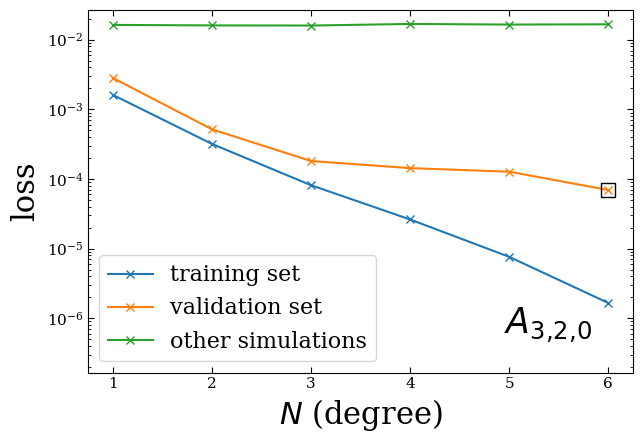

In [390]:
fig, ax = plt.subplots(figsize = (6.5, 4.5))

plot_to = 6

ax.semilogy(degrees[:plot_to], t_loss_list[:plot_to], label = 'training set', marker = 'x', c = 'C0')
ax.semilogy(degrees[:plot_to], v_loss_list[:plot_to], label = 'validation set', marker = 'x', c = 'C1')
ax.semilogy(degrees[:plot_to], full_loss_list[:plot_to], label = 'other simulations', marker = 'x', c = 'C2')

ax.plot(degrees[best_indx], v_loss_list[best_indx],
         marker = 's', markersize = 10, markerfacecolor = 'none', 
         markeredgewidth = 1, markeredgecolor = 'k')

ax.set_ylim(t_loss_list[best_indx]*0.1, None)

ax.set_xlabel('$N$ (degree)', fontsize = 22)
ax.set_ylabel('loss', fontsize = 22)

ax.text(0.925, 0.075, f'$A_{{{mode_string_plot_tex}}}$', fontsize=25, transform=ax.transAxes,
        horizontalalignment='right', verticalalignment='bottom')

ax.legend(fontsize = 16)

fig.tight_layout()
# plt.savefig(f'../../plots/loss_vs_degree_{mode_string_pro}.pdf')

In [391]:
best_degree = 6 #degrees[best_indx]

poly = PolynomialFeatures(degree=best_degree, include_bias=True)
poly_features = poly.fit_transform(X)
poly_features_full = poly.fit_transform(X_full)
X_t,X_v, y_t, y_v, w_t, w_v = train_test_split(poly_features,y,w,train_size=0.8,test_size=0.2,random_state=random_state)

length = X_t.shape[1]
X_t_copy = X_t.copy()
X_v_copy = X_v.copy()
X_full_copy = poly_features_full.copy()
del_indx_list = []
del_loss_list = [t_loss_list[best_indx]]
del_v_loss_list = [v_loss_list[best_indx]]
del_extra_v_loss_list = [full_loss_list[best_indx]]
for j in range(len(X_t[0])-1):
    del_indx = 1
    best_loss = np.inf
    for i in range(len(X_t_copy[0])):
        if i == 0:
            continue
        X_t_del = np.delete(X_t_copy, i, 1)
        X_v_del = np.delete(X_v_copy, i, 1)
        X_full_dell = np.delete(X_full_copy, i, 1)
        poly_reg_model_del = LinearRegression(fit_intercept = False)
        poly_reg_model_del.fit(X_t_del, y_t, sample_weight=w_t)
        loss = mse(y_t, poly_reg_model_del.predict(X_t_del), sample_weight=w_t)
        v_loss = mse(y_v, poly_reg_model_del.predict(X_v_del), sample_weight=w_v)
        extra_v_loss = mse(y_full, poly_reg_model_del.predict(X_full_dell), sample_weight=w_full)
        if loss < best_loss:
            best_loss = loss
            del_indx = i
    X_t_copy = np.delete(X_t_copy, del_indx, 1)
    X_v_copy = np.delete(X_v_copy, del_indx, 1)
    X_full_copy = np.delete(X_full_copy, del_indx, 1)
    del_indx_list.append(del_indx)
    del_loss_list.append(best_loss)
    del_v_loss_list.append(v_loss)
    del_extra_v_loss_list.append(extra_v_loss)

loss_list_order = del_loss_list[::-1]
v_loss_list_order = del_v_loss_list[::-1]
extra_v_loss_list_order = del_extra_v_loss_list[::-1]

In [392]:
x_points = (np.array(range(len(X_t[0]))) + 1)
v_loss_min = np.min(v_loss_list_order[:20])
best_term_indx = np.argmax(v_loss_list_order < v_loss_min*1.5)
best_term_num = x_points[best_term_indx]

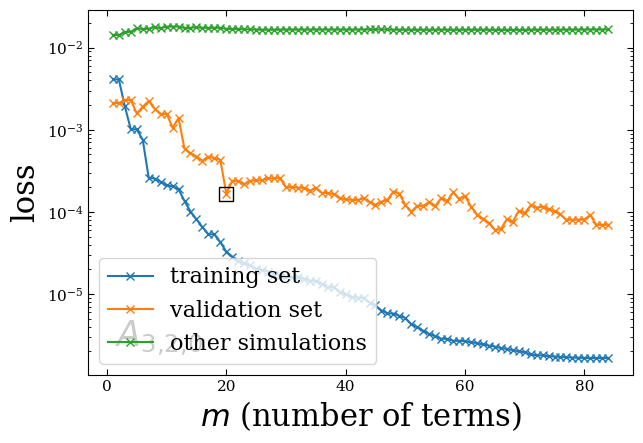

In [393]:
fig, ax = plt.subplots(figsize = (6.5, 4.5))

ax.semilogy(x_points, loss_list_order, label='training set', marker = 'x')
ax.semilogy(x_points, v_loss_list_order, label='validation set', marker = 'x')
ax.semilogy(x_points, extra_v_loss_list_order, label='other simulations', marker = 'x')
ax.plot(best_term_num, v_loss_list_order[best_term_indx], marker = 's', markersize = 10, markerfacecolor = 'none',
            markeredgewidth = 1, markeredgecolor = 'k')

ax.legend(fontsize = 16)
ax.set_xlabel('$m$ (number of terms)', fontsize = 22)
ax.set_ylabel('loss', fontsize = 22)

ax.text(0.05, 0.075, f'$A_{{{mode_string_plot_tex}}}$', fontsize=25, transform=ax.transAxes)

fig.tight_layout()
# plt.savefig(f'../../plots/loss_vs_n_terms_{mode_string_pro}.pdf')

In [394]:
indx_list = list(range(len(poly_features[0])))
original_indx_del_list = []
for indx in del_indx_list:
    original_indx_del_list.append(indx_list[indx])
    del indx_list[indx]
original_indx_del_list.append(indx_list[0])

In [395]:
original_indx_order = original_indx_del_list[::-1]

In [396]:
include_terms = original_indx_order[:best_term_num]

In [397]:
include_terms_sorted = np.sort(include_terms)

In [398]:
X_t_red = X_t[:,include_terms_sorted]
X_v_red = X_v[:,include_terms_sorted]
poly_red = LinearRegression()
poly_red.fit(X_t_red, y_t, sample_weight=w_t)

LinearRegression()

In [399]:
def to_sigfig(num, sigfig = 4):
    return np.format_float_positional(num, precision=sigfig, fractional = False, trim = '-')

In [400]:
def poly_expression_latex(powers, poly_red, variables = ['\eta', '\chi_+', '\chi_-'], sigfig = 4, real = False):
    save_array = []
    complex_intercept = poly_red.intercept_[0] + 1.j*poly_red.intercept_[1]
    save_array.append([0, 0, 0, poly_red.intercept_[0], poly_red.intercept_[1]])
    intercept_A = np.abs(complex_intercept)
    intercept_phi = np.angle(complex_intercept)
    if intercept_phi < 0:
        intercept_phi += 2*np.pi
    if real:
        if 3*np.pi/2 > intercept_phi > np.pi/2:
            expression = f'- {to_sigfig(intercept_A, sigfig = sigfig)}'
        else:
            expression = f'{to_sigfig(intercept_A, sigfig = sigfig)}'
    else:
        expression = f'{to_sigfig(intercept_A, sigfig = sigfig)} e^{{i {to_sigfig(intercept_phi, sigfig = sigfig)}}}'
    for p, power in enumerate(powers):
        if np.all(power == 0):
            continue
        complex_coeff = poly_red.coef_[0][p] + 1.j*poly_red.coef_[1][p]
        save_array.append([power[0], power[1], power[2], poly_red.coef_[0][p], poly_red.coef_[1][p]])
        coeff_A = np.abs(complex_coeff)
        coeff_phi = np.angle(complex_coeff)
        if coeff_phi < 0:
            coeff_phi += 2*np.pi
        if real:
            if 3*np.pi/2 > coeff_phi > np.pi/2:
                coef_expression = f' - {to_sigfig(coeff_A, sigfig = sigfig)}'
            else:
                coef_expression = f' + {to_sigfig(coeff_A, sigfig = sigfig)}'
        else:
            coef_expression = f' + {to_sigfig(coeff_A, sigfig = sigfig)} e^{{i {to_sigfig(coeff_phi, sigfig = sigfig)}}}'
        expression += coef_expression
        for i in range(len(power)):
            if power[i] == 0:
                continue
            if power[i] == 1:
                expression += f' {variables[i]}'
            else:
                expression += f' {variables[i]}^{power[i]}'
    save_array = np.array(save_array)
    return expression, save_array

In [401]:
from IPython.display import display, Math

In [402]:
tex_expression, save_array = poly_expression_latex(poly.powers_[include_terms_sorted], poly_red, real = (mode_string_pro == '2.2.0'))
display(Math(tex_expression))

<IPython.core.display.Math object>

In [403]:
# with open(f'./fit_expressions/hyperfit_tex_{mode_string_pro}.txt', 'w') as f:
#     f.write(tex_expression)

# np.savetxt(f'./fit_expressions/hyperfit_array_{mode_string_pro}.csv', save_array)

In [404]:
# y_pred = models[best_indx].predict(poly_features_list[best_indx])
y_pred = poly_red.predict(poly_features[:, include_terms_sorted])
y_pred_full = poly_red.predict(poly_features_full[:, include_terms_sorted])

In [405]:
df_mode_3D['A_pred'] = (y_pred[:,0] + 1.j*y_pred[:,1])*PN_func(df_mode_3D['eta'])
df_mode_3D['A_pred_norm'] = np.abs(df_mode_3D['A_pred'])
df_mode_3D['A_pred_err'] = np.abs(df_mode_3D['A_pred'] - df_mode_3D['A_comp_unadj'])
df_mode_3D['A_pred_rel_err'] = np.abs(df_mode_3D['A_pred_err']/df_mode_3D['A_comp_unadj'])
df_mode_3D['A_pred_log'] = np.log10(df_mode_3D['A_pred'])
df_mode_3D['A_pred_err_log'] = np.log10(df_mode_3D['A_pred_err'])
df_mode_3D['A_pred_rel_err_log'] = np.log10(df_mode_3D['A_pred_rel_err'])
df_mode_3D['A_pred_err_sig'] = df_mode_3D['A_pred_rel_err']/df_mode_3D['A_range']

In [406]:
df_mode_3D_full['A_pred'] = (y_pred_full[:,0] + 1.j*y_pred_full[:,1])*PN_func(df_mode_3D_full['eta'])
df_mode_3D_full['A_pred_norm'] = np.abs(df_mode_3D_full['A_pred'])
df_mode_3D_full['A_pred_err'] = np.abs(df_mode_3D_full['A_pred'] - df_mode_3D_full['A_comp_unadj'])
df_mode_3D_full['A_pred_rel_err'] = np.abs(df_mode_3D_full['A_pred_err']/df_mode_3D_full['A_comp_unadj'])
df_mode_3D_full['A_pred_log'] = np.log10(df_mode_3D_full['A_pred'])
df_mode_3D_full['A_pred_err_log'] = np.log10(df_mode_3D_full['A_pred_err'])
df_mode_3D_full['A_pred_rel_err_log'] = np.log10(df_mode_3D_full['A_pred_rel_err'])
df_mode_3D_full['A_pred_err_sig'] = df_mode_3D_full['A_pred_rel_err']/df_mode_3D_full['A_range']

In [407]:
df_mode_3D.sort_values('A_pred_rel_err', ascending = False)[['SXS_num', 'eta', 'q', 'chi_rem', 'A_med', 'A_comp', 'A_pred', 'A_pred_rel_err', 'A_pred_err']][:10]

SXS_num       eta         q   chi_rem     A_med    A_comp  \
1769      284  0.187505  2.999854  0.695734  0.002477  0.013209   
909       253  0.222225  1.999934  0.804636  0.003282  0.014767   
809       248  0.222238  1.999566  0.711587  0.010789  0.048546   
871       251  0.222223  1.999970  0.734375  0.004582  0.020621   
989       256  0.222224  1.999957  0.838563  0.002963  0.013331   
1891      288  0.187500  3.000005  0.785440  0.003326  0.017739   
4638     1478  0.223230  1.972788  0.871161  0.012935  0.057947   
756       246  0.222227  1.999861  0.641034  0.006257  0.028156   
4347     1468  0.212382  2.267472  0.811883  0.010694  0.050351   
1103      260  0.187524  2.999230  0.124471  0.018037  0.096183   

                  A_pred  A_pred_rel_err  A_pred_err  
1769  0.006133+0.000000j        1.475969    0.003656  
909   0.005887+0.000000j        0.793944    0.002605  
809   0.002260+0.000000j        0.790503    0.008528  
871   0.007967+0.000000j        0.738576    0.003385  
989   0.004884+0.000000j        0.648675    0.001922  
1891  0.005103+0.000000j        0.534296    0.001777  
4638  0.006874+0.000000j        0.468621    0.006062  
756   0.009093+0.000000j        0.453177    0.002836  
4347  0.006025+0.000000j        0.436553    0.004668  
1103  0.025900+0.000000j        0.435943    0.007863

In [408]:
df_mode_3D_full.sort_values('A_pred_rel_err', ascending = False)[['SXS_num', 'eta', 'q', 'chi_rem', 'A_med', 'A_pred_rel_err', 'A_pred_err']][:10]

SXS_num       eta         q   chi_rem     A_med  A_pred_rel_err  \
310         45  0.187506  2.999804  0.741007  0.002188        3.535261   
10537     2160  0.187498  3.000070  0.785484  0.003330        2.531815   
9086      2125  0.222220  2.000058  0.734319  0.004684        2.503808   
5216       631  0.210300  2.325001  0.531917  0.006819        2.420576   
5793      1166  0.222222  2.000015  0.623428  0.008256        2.367676   
1111       184  0.222223  1.999981  0.623439  0.008438        2.339796   
875        169  0.222222  1.999997  0.623439  0.008423        2.339580   
5829      1167  0.222218  2.000108  0.623388  0.008439        2.338853   
6110      1222  0.222233  1.999708  0.623453  0.008475        2.329796   
6335      1369  0.222225  1.999914  0.625389  0.008841        2.278279   

       A_pred_err  
310      0.007737  
10537    0.008432  
9086     0.011728  
5216     0.016506  
5793     0.019548  
1111     0.019743  
875      0.019707  
5829     0.019737  
6110     0.019745  
6335     0.020142

array([[<AxesSubplot: title={'center': 'A_pred_rel_err_log'}>]],
      dtype=object)

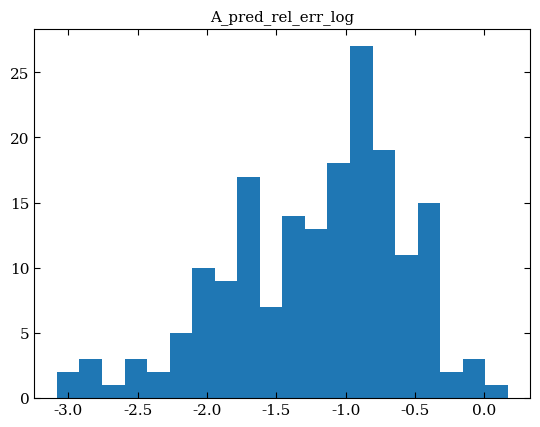

In [409]:
df_mode_3D.hist('A_pred_rel_err_log', bins = 20, grid = False)

In [410]:
# color the histogram according to A_range/A
rel_err_min = df_mode_3D['A_pred_rel_err_log'].min()
rel_err_max = df_mode_3D['A_pred_rel_err_log'].max()
rel_err_color_list = np.linspace(rel_err_min, rel_err_max, 11)
cmap_val_list = np.linspace(0, 1, 11)
bins = np.linspace(0, df_mode_3D["A_pred_err_sig"].max(), 20)

In [411]:
from matplotlib.cm import get_cmap

cmap = get_cmap('viridis')

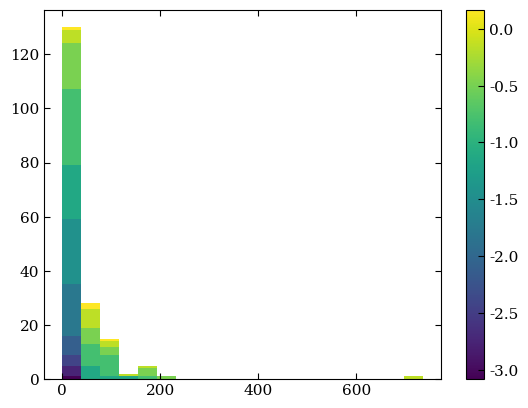

In [412]:
fig, ax = plt.subplots()

for cmap_val, rel_err_color in zip(cmap_val_list[::-1], rel_err_color_list[::-1]):
    ax.hist(df_mode_3D[df_mode_3D["A_pred_rel_err_log"] <= rel_err_color]['A_pred_err_sig'], 
            bins = bins,
            color = cmap(cmap_val))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=rel_err_min, vmax=rel_err_max))
sm._A = []
cbar = fig.colorbar(sm, ax = ax)


In [413]:
df_mode_3D_copy = df_mode_3D.copy()
df_mode_3D_copy.sort_values('A_med', ascending = True, inplace = True)

/home/markc/jaxqualin/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning:

Casting complex values to real discards the imaginary part



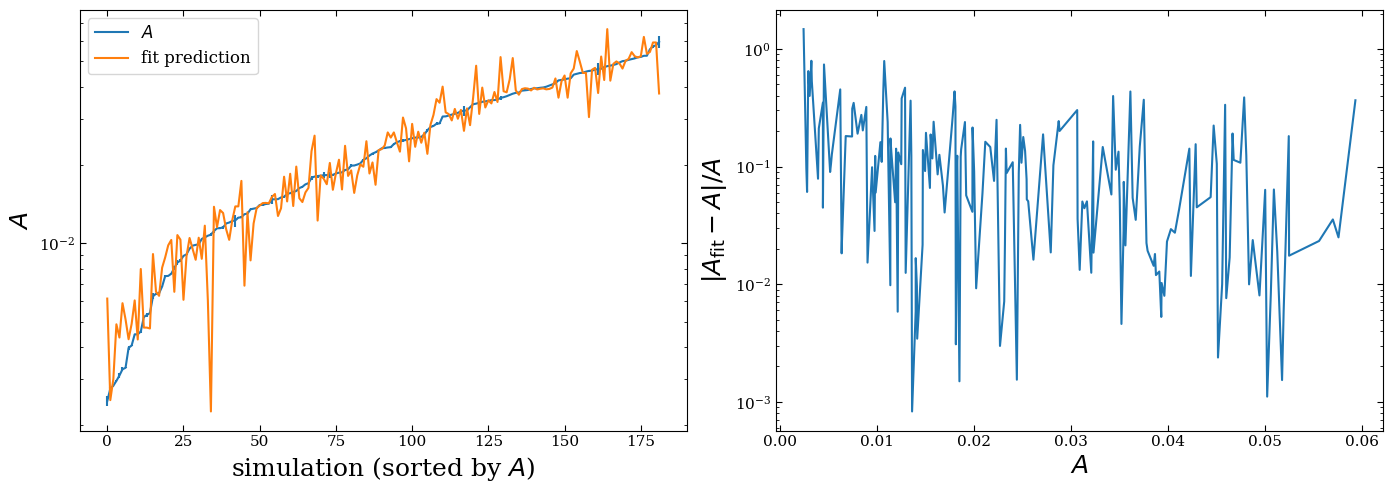

In [414]:
fig, axs = plt.subplots(1, 2, figsize = (14, 5))
axs[0].semilogy(df_mode_3D_copy['A_med'].to_numpy(), label = r'$A$')
axs[0].errorbar(range(len(df_mode_3D_copy)), df_mode_3D_copy['A_med'].to_numpy(), 
             yerr = df_mode_3D_copy['A_med'].to_numpy()*df_mode_3D_copy['A_range'].to_numpy(), fmt = 'none',
             )
axs[0].semilogy(df_mode_3D_copy['A_pred'].to_numpy(), label = r'fit prediction')
axs[0].set_xlabel(r'simulation (sorted by $A$)')
axs[0].set_ylabel(r'$A$')
axs[0].legend()

axs[1].semilogy(df_mode_3D_copy['A_med'].to_numpy(), np.abs(df_mode_3D_copy['A_med'].to_numpy() - df_mode_3D_copy['A_pred'].to_numpy())/df_mode_3D_copy['A_med'].to_numpy())
axs[1].set_xlabel(r'$A$')
axs[1].set_ylabel(r'$|A_{\rm fit} - A|/A$')

fig.tight_layout()
plt.savefig(f'../../plots/A_fit_vs_A_{mode_string_pro}.pdf')
# plt.savefig(f'../../plots/A_fit_vs_A_{mode_string_pro}.png', dpi = 300, bbox_inches = 'tight', transparent = False, facecolor='white')

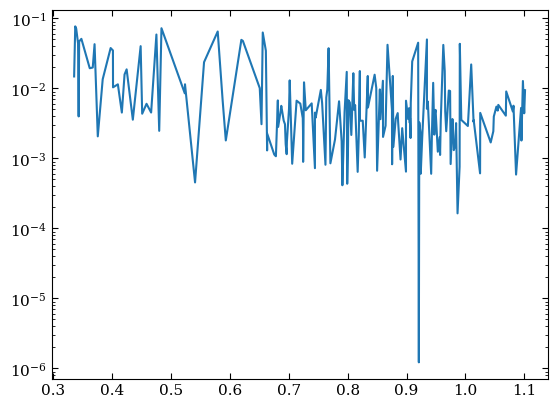

In [58]:
plt.semilogy(df_mode_3D_copy['A_med'].to_numpy(), np.abs(df_mode_3D_copy['A_med'].to_numpy() - df_mode_3D_copy['A_pred_norm'].to_numpy())/df_mode_3D_copy['A_med'].to_numpy())

In [502]:
import plotly.express as px
fig = px.scatter_3d(df_mode_3D, x='chi_p', y='chi_m', z='eta',
                    color='A_pred_rel_err_log', size='A_range_adj_abs_rel_inv', size_max=50,
                    hover_name = 'SXS_num',
                    hover_data = ['A_med', 'A_pred_norm', 'A_med_adj', 'chi_1_z', 'chi_2_z', 'q', 'chi_rem', 'A_range'])
fig.show()

In [1076]:
import plotly.express as px
fig = px.scatter_3d(df_mode_3D, x='chi_p', y='chi_m', z='eta',
                    color='A_pred_rel_err_log', size='A_range_inv', size_max=50,
                    hover_name = 'SXS_num',
                    hover_data = ['A_med', 'A_pred_norm', 'A_med_adj', 'chi_1_z', 'chi_2_z', 'q', 'chi_rem', 'A_range'])
fig.show()

In [1077]:
import plotly.express as px
fig = px.scatter_3d(df_mode_3D, x='chi_p', y='chi_m', z='eta',
                    color='A_med', size='A_range_inv', size_max=50,
                    hover_name = 'SXS_num',
                    hover_data = ['A_med', 'A_pred_norm', 'chi_1_z', 'chi_2_z', 'q', 'chi_rem', 'A_range'])
fig.show()

In [1078]:
import plotly.express as px
fig = px.scatter_3d(df_mode_3D, x='chi_p', y='chi_m', z='eta',
                    color='A_pred_norm', size='A_range_inv', size_max=50,
                    hover_name = 'SXS_num',
                    hover_data = ['A_med', 'A_pred_norm', 'chi_1_z', 'chi_2_z', 'q', 'chi_rem', 'A_range'])
fig.show()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df_mode_3D_full, x='chi_p', y='chi_m', z='eta',
                    color='A_pred_rel_err_log', size='A_range_inv', size_max=50,
                    hover_name = 'SXS_num',
                    hover_data = ['A_med', 'A_med_adj', 'A_pred', 'chi_1_z', 'chi_2_z', 'q', 'chi_rem', 'A_range'])
fig.show()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df_mode_3D_full, x='chi_p', y='chi_m', z='eta',
                    color='A_med', size='A_range_inv', size_max=50,
                    hover_name = 'SXS_num',
                    hover_data = ['A_med', 'A_pred', 'chi_1_z', 'chi_2_z', 'q', 'chi_rem', 'A_range'])
fig.show()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df_mode_3D_full, x='chi_p', y='chi_m', z='eta',
                    color='A_pred', size='A_range_inv', size_max=50,
                    hover_name = 'SXS_num',
                    hover_data = ['A_med', 'A_pred', 'chi_1_z', 'chi_2_z', 'q', 'chi_rem', 'A_range'])
fig.show()